<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Session-6/S6B_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

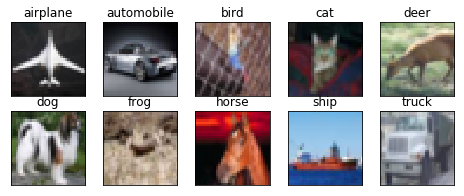

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
# summarize dataset shape
print('Train', train_features.shape, train_labels.shape)
print('Test', (test_features.shape, test_labels.shape))
# summarize pixel values
print('Train', train_features.min(), train_features.max(), train_features.mean(), train_features.std())
print('Test', test_features.min(), test_features.max(), test_features.mean(), test_features.std())

Train (50000, 32, 32, 3) (50000, 10)
Test ((10000, 32, 32, 3), (10000, 10))
Train 0.0 1.0 0.4733649 0.25156906
Test 0.0 1.0 0.47658524 0.25121963


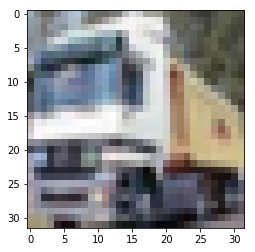

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(train_features[1])

#### Performing Image Normalization

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, merge
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D 

In [13]:

input_shape = (32,32)+(3,)
img_input = Input(shape = input_shape)

# Normal Convolution 
x = Conv2D(32,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(img_input)#(3*3,32*32) of the form (effective global receptive field,output channel size )
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# Spatially Seperable Convolutions if used should be used early in the network
x = Conv2D(32,kernel_size=(3,1),strides=1,padding = 'same',data_format='channels_last',use_bias=False)(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
x = Conv2D(64,kernel_size=(1,3),strides=1,padding = 'same',data_format='channels_last',use_bias=False)(x) #(5*5,32*32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# adding bottleneck layer i.e 1*1 convolutions followed by a max-pooling layer
x = Conv2D(32, 1,strides=1,data_format='channels_last',use_bias=False )(x) #(5*5,32*32)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(10*10,16*16)
x = Dropout(0.1)(x)

# the following code till concatenate represents Grouped convolution using 3*3 and 5*5 Convolutions with 
# Depthwise Separable Convolution
x = SeparableConv2D(64,3,strides=1,padding='same',data_format='channels_last',use_bias=False)(x) #(12*12,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

skip_tensor = x

x = Conv2D(128,3,strides=1,padding = 'same',data_format='channels_last',use_bias=False)(x) #(14*14,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = concatenate([skip_tensor, x])

# Applying Bottleneck layer 
x = Conv2D(32,1,strides=1,data_format='channels_last',use_bias=False)(x) #(14*14,16*16)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2),data_format='channels_last')(x) #(28*28,8*8)
x = Dropout(0.1)(x)                
 
#  The following code block till concatenate represents Grouped Convolution (use 3x3 only, two with dilation = 1, and another with dilation = 2) 
x = Conv2D(32,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 1,use_bias=False)(x) #(30*30,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Conv2D(32,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 1,use_bias=False)(x) #(32*32,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

skip_tensor = x
  
x = Conv2D(64,3,strides=1,padding='same',data_format='channels_last',dilation_rate = 2,use_bias=False)(x) #(36*36,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)  
x = Dropout(0.1)(x)

x = concatenate([skip_tensor, x])

x = Conv2D(10, 1,strides=1,data_format='channels_last',use_bias=False)(x) #(36*36,8*8)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

# Normal convolution layer with higher kernel
x = Conv2D(num_classes,(8,8))(x) #(44*44,1*1)
x = Flatten()(x)
output = Activation('softmax')(x)
                



W0904 17:04:34.211565 139785811695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 17:04:34.237451 139785811695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 17:04:34.242833 139785811695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 17:04:34.279047 139785811695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 17:04:34.279958 1397858116

In [0]:
model = Model(inputs=img_input, outputs=output)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [16]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

W0904 17:04:37.375631 139785811695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# checkpoint
filepath="./Assignment6_19_2019-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,LearningRateScheduler(scheduler, verbose=1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  # This is added back by InteractiveShellApp.init_path()
W0904 17:04:37.799373 139785811695488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_di

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 38s 97ms/step - loss: 1.4608 - acc: 0.4665 - val_loss: 2.0135 - val_acc: 0.3647

Epoch 00001: val_acc improved from -inf to 0.36470, saving model to ./Assignment6_19_2019-01-0.36.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 30s 77ms/step - loss: 1.0441 - acc: 0.6245 - val_loss: 0.9702 - val_acc: 0.6640

Epoch 00002: val_acc improved from 0.36470 to 0.66400, saving model to ./Assignment6_19_2019-02-0.66.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 30s 77ms/step - loss: 0.8744 - acc: 0.6876 - val_loss: 0.8713 - val_acc: 0.6997

Epoch 00003: val_acc improved from 0.66400 to 0.69970, saving model to ./Assignment6_19_2019-03-0.70.hdf5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0

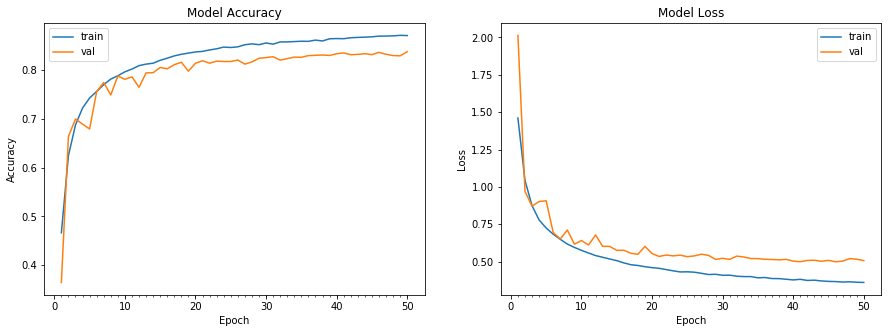

Accuracy on test data is: 83.77


In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callbacks_list )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))